# Ejercicio

Para el siguiente ejemplo implementaremos una red CNN y adicionalmente mecanismos para extraer información de las CONV Layers para identificar mapas de calor (Attention maps)

Los modelos de detección de COVID-19 que utilizan imágenes de rayos X implican el uso de algoritmos de aprendizaje automático para analizar imágenes de rayos X del tórax con el fin de identificar patrones y características asociados con las infecciones por COVID-19. 

Estos modelos se entrenan con grandes conjuntos de datos de imágenes de rayos X que han sido etiquetadas como positivas o negativas para COVID-19, y luego pueden usarse para predecir la probabilidad de una infección por COVID-19 en función de las características presentes en una nueva radiografía. imagen de rayos.

Un beneficio potencial del uso de imágenes de rayos X para la detección de COVID-19 es que los rayos X son relativamente baratos y están ampliamente disponibles, lo que los convierte en una herramienta práctica para la detección y el diagnóstico masivos. Además, las imágenes de rayos X pueden proporcionar información importante sobre la gravedad de una infección por COVID-19, como el alcance del daño pulmonar o la presencia de otras afecciones respiratorias.

Si bien las imágenes de rayos X por sí solas pueden no ser suficientes para el diagnóstico definitivo de COVID-19, pueden ser un componente valioso de un enfoque multimodal para la detección de COVID-19 que incluye otras pruebas de diagnóstico como la prueba de PCR (reacción en cadena de la polimerasa) y pruebas de anticuerpos.

>NOTE: En el caso de usar Kaggle el dataset lo importan directamente del siguiente link [Covid19-Radiography-Database](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/). De usar Colab o correrlo localmente, deben descargar el dataset, descomprimirlo y corregir los paths (directorios) de acuerdo a tu configuración

# Instalación de paquetes

## LIVELOSSPLOT

Livelossplot es una biblioteca de Python que se puede utilizar para crear gráficos en vivo de métricas de evaluación y pérdida durante el entrenamiento de modelos de aprendizaje automático. A menudo se utiliza en combinación con marcos de aprendizaje profundo como Keras y PyTorch.

Livelossplot permite a los usuarios visualizar el progreso del entrenamiento de su modelo en tiempo real, lo que puede resultar útil para identificar tendencias, depurar y optimizar el rendimiento del modelo. Es especialmente útil al entrenar modelos de aprendizaje profundo, cuyo entrenamiento puede ser complejo y llevar mucho tiempo.

Para usar livelossplot, los usuarios simplemente necesitan especificar las métricas de pérdida y evaluación que desean rastrear, y la biblioteca creará un gráfico dinámico que se actualiza a medida que se entrena el modelo. Los usuarios también pueden personalizar la apariencia del gráfico, como los colores, los estilos de línea y las etiquetas de leyenda.


In [2]:
!pip install livelossplot
!pip install albumentations
!pip install plotly

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
import keras
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Clasificación de imágenes

Aquí las imágenes se clasifican en clases y su ruta se recopila y guarda en un marco de datos que puede usarse para manipulación posterior.

In [4]:
files = ['COVID', 'Lung_Opacity', 'Normal','Viral Pneumonia'] #TODO - Hint revisar el dataset y el nombre de los directorios
path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset" #TODO completar con Path
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()

,image_file,corona_result,path
0,COVID/images/COVID-1994.png,Covid_positive,/kaggle/input/covid19-radiography-database/COV...
1,COVID/images/COVID-1825.png,Covid_positive,/kaggle/input/covid19-radiography-database/COV...
2,COVID/images/COVID-517.png,Covid_positive,/kaggle/input/covid19-radiography-database/COV...
3,COVID/images/COVID-532.png,Covid_positive,/kaggle/input/covid19-radiography-database/COV...
4,COVID/images/COVID-2272.png,Covid_positive,/kaggle/input/covid19-radiography-database/COV...


In [5]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))


Number of Duplicated Samples: 0
Number of Total Samples: 21165


El número total de imágenes utilizadas es 21165 como consolidación de todas las clases.

In [6]:
no_of_samples = 21165
df = pd.DataFrame()
df['corona_result'] = ['COVID', 'Lung_Opacity', 'Normal','Viral Pneumonia'] #TODO - Hint revisar el dataset y el nombre de los directorios
df['Count'] = [len(data[data['corona_result'] == 'Normal']), len(data[data['corona_result'] == 'Covid_positive']), len(data[data['corona_result'] == 'Lung_Opacity']), len(data[data['corona_result'] == 'Viral_Pneumonia'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result",  width = 600, 
             color_continuous_scale='BrBg')

fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

El siguiente script de código sirve para convertir la ruta de la imagen en una matriz numerosa y guardarla en el marco de datos. Aquí no utilizamos ninguna función sencilla como tensorflow flow_from_directory y etc. para facilitar la transformación de esta imagen en matriz.

In [7]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

In [8]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, no_of_samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

In [9]:
mean_normal = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
mean_covid = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
mean_opacity = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
mean_pneumonia = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
mean_list = [mean_normal,mean_covid,mean_opacity,mean_pneumonia]

max_normal = imageEDA["max"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
max_covid = imageEDA["max"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
max_opacity = imageEDA["max"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
max_pneumonia = imageEDA["max"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
max_list = [max_normal,max_covid,max_opacity,max_pneumonia]

min_normal = imageEDA["min"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
min_covid = imageEDA["min"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
min_opacity = imageEDA["min"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
min_pneumonia = imageEDA["min"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
min_list = [min_normal,min_covid,min_opacity,min_pneumonia]

std_normal = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
std_covid = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
std_opacity = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
std_pneumonia = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
std_list = [std_normal,std_covid,std_opacity,std_pneumonia]

Names = ['Normal','Covid','Lung opacity','Pneumonia']

In [10]:
def min_max_plot(data,name,title):
    colors = ['#04EEFF', '#4BBBFF', '#F5F232', '#7FFF00']

    # Create distplot with curve_type set to 'normal'
    fig = ff.create_distplot(data, name, show_hist=False, colors = colors)
    fig.update_layout(title_text=title,
                      titlefont={'size': 20},
                     template="plotly_dark",
                     width=800,height=600,)
    fig.show()

# Visualizando imágenes

Para comenzar, visualicemos algunas imágenes de las cuatro clases.

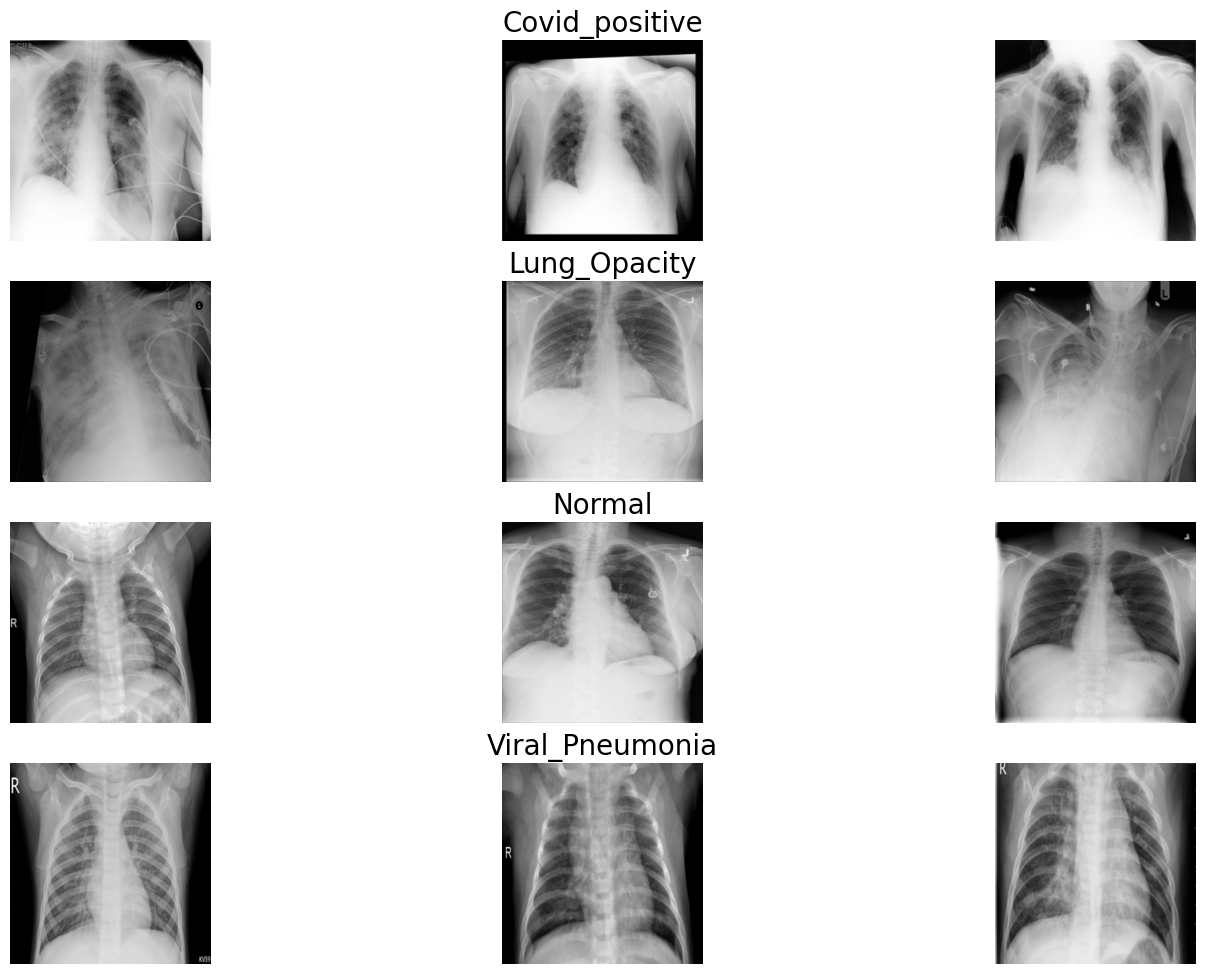

In [11]:
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 20)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')


# ALBUMENTATION (Data Augmentation Library)

`Albumentation` es una biblioteca de Python para el aumento de imágenes. El aumento de imágenes se refiere al proceso de aplicar varias modificaciones a una imagen, como cambiar el tamaño, rotarla, recortarla o agregar ruido, para aumentar los datos de entrenamiento para los modelos de aprendizaje automático. El objetivo del aumento de imágenes es mejorar la generalización y la solidez de los modelos de aprendizaje automático exponiéndolos a una gama más amplia de datos durante el entrenamiento.


Algunos usos específicos de la albumentación incluyen:

1. **Aumento de datos**: la albumentación se puede utilizar para crear datos de entrenamiento adicionales aplicando varias transformaciones a las imágenes existentes. Esto puede resultar especialmente útil cuando se trabaja con conjuntos de datos pequeños o desequilibrados, ya que puede ayudar a mejorar el rendimiento de los modelos de aprendizaje automático al aumentar la cantidad de datos de entrenamiento disponibles.

2. **Preprocesamiento**: la albumentación también se puede utilizar para preprocesar datos de imágenes aplicando transformaciones como escalado, normalización o cambio de tamaño a los datos. Esto puede ayudar a garantizar que los datos estén en un formato adecuado para los modelos de aprendizaje automático y puede mejorar el rendimiento de los modelos.

3. **Visualización**: la albumentación se puede utilizar para visualizar las transformaciones aplicadas a una imagen, lo que puede resultar útil para comprender los efectos de las transformaciones y depurar cualquier problema que pueda surgir.



In [12]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, axis = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        axis[i // ncols][i % ncols].imshow(img)
        axis[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()


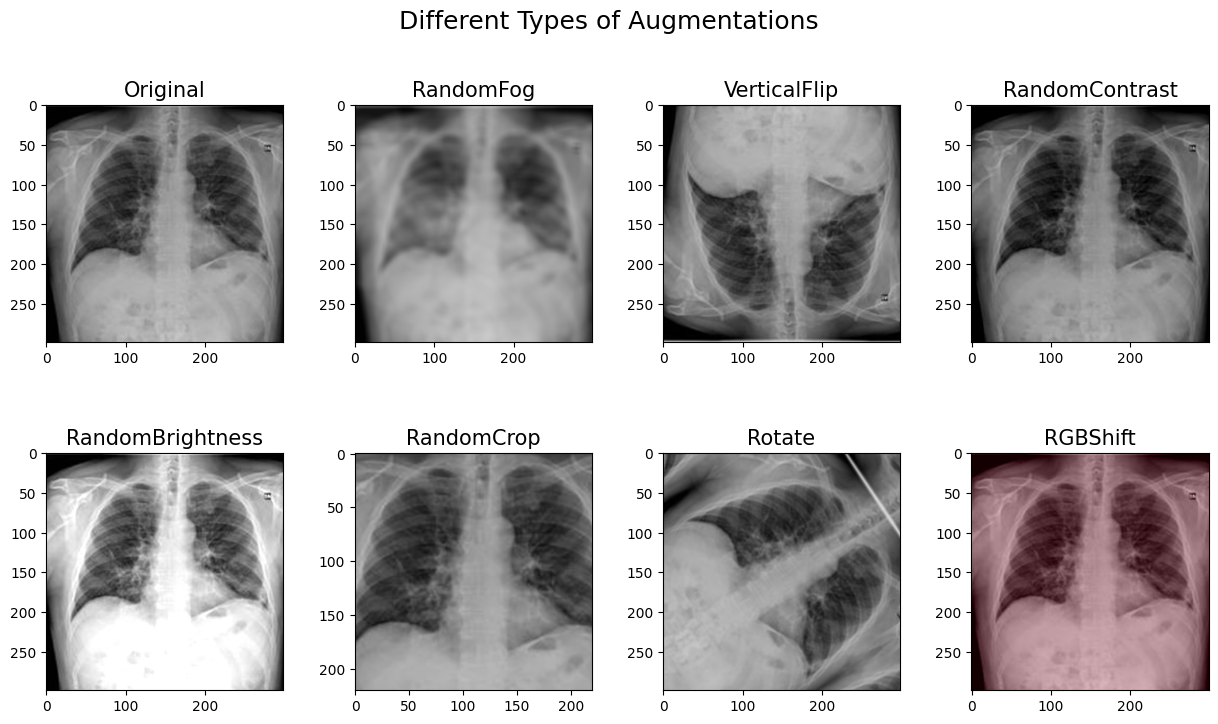

In [13]:
chosen_image = cv2.imread("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-101.png") #TODO - Cambiar path

albumentation_list = [A.RandomFog(p = 1),A.VerticalFlip(p = 1), A.RandomBrightness(p = 1),A.RandomContrast(limit = 0.6, p = 1),
                      A.RandomCrop(p = 1,height = 220, width = 220),
                      A.Rotate(p = 1, limit = 90), A.RGBShift(p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "VerticalFlip", "RandomContrast", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")


# Modelado
## Data Labeling

Establezcamos la etiqueta categórica en valor numérico.

In [14]:
all_data = []

# Storing images and their labels into a list for further Train Test split
{'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'}
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 0
    if data['corona_result'][i] == "Normal":
        label = 0
    elif data['corona_result'][i] == "Covid_positive":
        label = 1
    elif data['corona_result'][i] == "Lung_Opacity":
        label = 2
    else:
        label = 3

    all_data.append([image, label])

# Train | Test | Validation - split



In [15]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x,y , test_size =0.2 , random_state = 42) #TODO
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train , test_size =0.1 , random_state = 42) #TODO

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)


(15238, 70, 70, 3) (4233, 70, 70, 3) (1694, 70, 70, 3) (15238,) (4233,) (1694,)


We will be using 15238 images for training, 4233 images for testing, 1694 images for validation ~ 

# CNN model definition

Usaremos el modelo CNN con 3 capas convolucionales. Puedes utilizar la siguiente información como referencia.

**Capa 1** - filtro = 128, activación = unidad lineal rectificada

**Capa 2** - filtro = 64, activación = unidad lineal rectificada

**Capa 3** - filtro = 32, activación = unidad lineal rectificada

El optimizador utilizado es ADAM.

Pérdida => `SparseCategoricalCrossentropy`

Métricas => `accuracy`

In [16]:
from keras.layers import Dense, Dropout, Activation

def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    
    #TODO Layer 1
    cnn_model.add(Dense(128, input_shape=(70,70,3))) # Hidden Layer
    cnn_model.add(Activation('relu'))

    #TODO Layer 2
    cnn_model.add(Dense(64, input_shape=(70,70,3))) # Hidden Layer
    cnn_model.add(Activation('relu'))

    #TODO Layer 3
    cnn_model.add(Dense(32, input_shape=(70,70,3))) # Hidden Layer
    cnn_model.add(Activation('relu'))
    
    cnn_model.add(layers.Flatten())
    
    cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
    cnn_model.add(layers.Dropout(0.2))

    cnn_model.add(layers.Dense(units = 4))

    cnn_model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), #TODO función perdida (completar luego del `.`)
               metrics = ['accuracy']) #TODO Layer 1

    cnn_model.summary()
    return cnn_model

Tenemos cuatro clases como [Normal, COVID, Lung_Opacity, Pneumonia]

In [17]:
input_shape = (70, 70, 3)
n_classes= 4

conv_model = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70, 70, 128)       512       
                                                                 
 activation (Activation)     (None, 70, 70, 128)       0         
                                                                 
 dense_1 (Dense)             (None, 70, 70, 64)        8256      
                                                                 
 activation_1 (Activation)   (None, 70, 70, 64)        0         
                                                                 
 dense_2 (Dense)             (None, 70, 70, 32)        2080      
                                                                 
 activation_2 (Activation)   (None, 70, 70, 32)        0         
                                                                 
 flatten (Flatten)           (None, 156800)            0

# Callback definition

## PlotLossesCallback()

`PlotLossesCallback()` es una función de la biblioteca `livelossplot` que permite a los usuarios trazar las pérdidas de entrenamiento y validación durante el entrenamiento de un modelo de aprendizaje profundo. La función funciona creando un gráfico de las pérdidas y actualizándolo en tiempo real a medida que se entrena el modelo. Esto puede resultar útil para comprender cómo se está desempeñando el modelo durante el entrenamiento, identificar tendencias o patrones en las pérdidas y depurar cualquier problema que pueda surgir.

## ModelCheckpoint()

`ModelCheckpoint()` es una función en la biblioteca de Keras que permite a los usuarios guardar los pesos de un modelo de aprendizaje profundo durante el proceso de entrenamiento. La función funciona guardando periódicamente los pesos del modelo en un archivo específico, lo que permite a los usuarios interrumpir y reanudar el entrenamiento más adelante si es necesario.

## EarlyStopping()

`EarlyStopping()` es una función de devolución de llamada en la biblioteca de Keras que permite a los usuarios especificar cuándo dejar de entrenar un modelo de aprendizaje profundo en función del rendimiento del modelo en un conjunto de datos de validación. La función funciona monitoreando una métrica específica (por ejemplo, precisión o pérdida) y deteniendo el entrenamiento cuando la métrica deja de mejorar o comienza a degradarse. Esto puede resultar útil para evitar el sobreajuste y garantizar que el modelo pueda generalizarse a nuevos datos.

In [54]:
plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy', #TODO 
                           patience=10, #TODO 
                           restore_best_weights=True,
                           mode='min')

Entrenemos nuestro modelo con datos de entrenamiento.

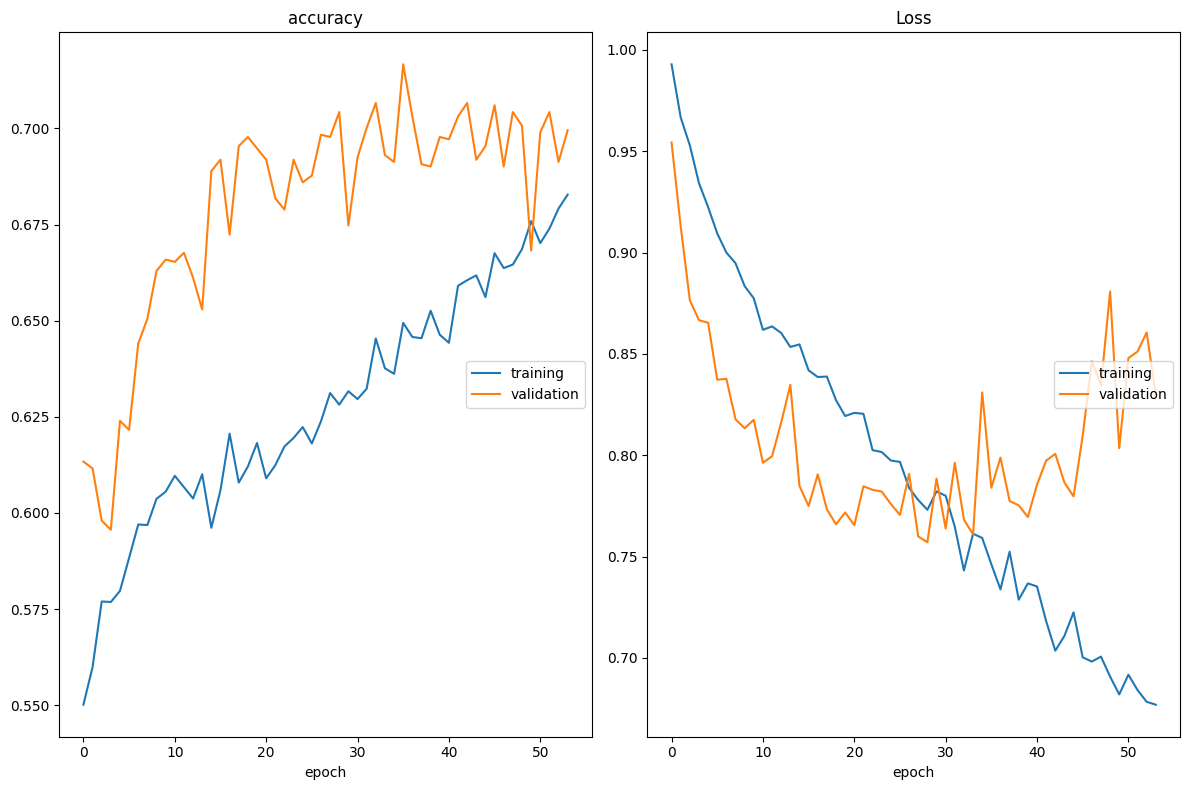

accuracy
	training         	 (min:    0.550, max:    0.683, cur:    0.683)
	validation       	 (min:    0.596, max:    0.717, cur:    0.700)
Loss
	training         	 (min:    0.677, max:    0.993, cur:    0.677)
	validation       	 (min:    0.757, max:    0.954, cur:    0.830)

Epoch 54: val_loss did not improve from 0.75707
60/60 [==============================] - 6s 106ms/step - loss: 0.6769 - accuracy: 0.6828 - val_loss: 0.8300 - val_accuracy: 0.6995
CPU times: user 4min 49s, sys: 25.8 s, total: 5min 15s
Wall time: 5min 52s


In [55]:
%%time

plot_loss_2 = PlotLossesCallback()

conv_history = conv_model.fit(x_train, #TODO 
                              y_train, #TODO 
                              epochs = 100, #TODO 
                              batch_size = 256,  
                              validation_data = (x_val, y_val), 
                              callbacks = [plot_loss_1,tl_checkpoint_1, early_stop], 
                              #TODO callbacks - agregar los 3 definidos
                              verbose=1)


Hagamos una predicción mediante nuestro modelo que pueda usarse para validar el modelo.

In [56]:
yp_train = conv_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = conv_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = conv_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

133/133 [==============================] - 1s 6ms/step


# Model validation

In [57]:
def confusion_matrix_train_test_val(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")

    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")


In [58]:
confusion_matrix_train_test_val("CNN", y_train, yp_train, y_val, yp_val, y_test, yp_test)


-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.65      0.91      0.76      7334
           1       0.00      0.00      0.00      2639
           2       0.49      0.57      0.52      4290
           3       0.00      0.00      0.00       975

    accuracy                           0.60     15238
   macro avg       0.29      0.37      0.32     15238
weighted avg       0.45      0.60      0.51     15238

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.66      0.91      0.76       834
           1       0.00      0.00      0.00       276
           2       0.46      0.52      0.49       476
           3       0.00      0.00      0.00       108

    accuracy                           0.60      1694
   macro avg      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

### <b><span style='color:#274C5C'>Model performance over accuracy</span></b>

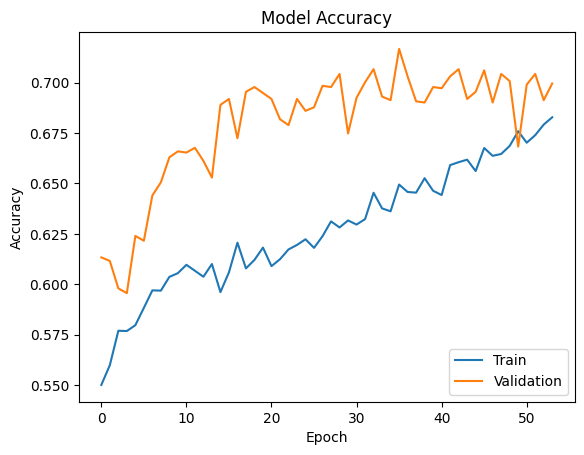

In [59]:
# Summarize History for Accuracy

plt.plot(conv_history.history['accuracy'])
plt.plot(conv_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()


### <b><span style='color:#274C5C'>Model performance over loss</span></b>

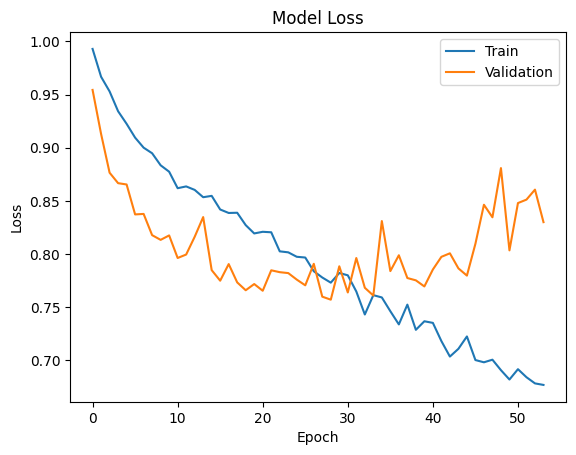

In [60]:
# Summarize History for Loss

plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()


### <b><span style='color:#274C5C'>Model performance over accuracy / loss</span></b>

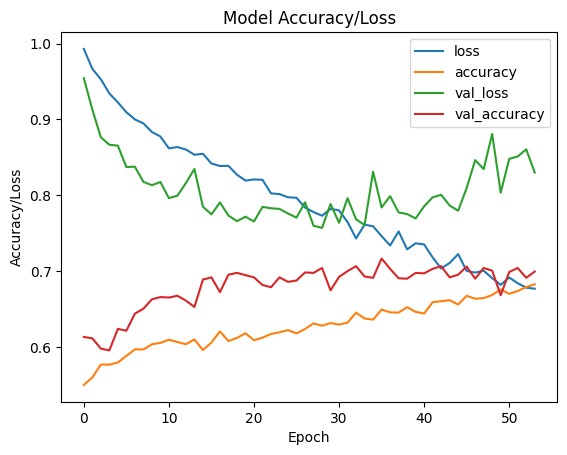

In [61]:
# Accuracy Loss Graph

pd.DataFrame(conv_history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()


In [62]:
conv_model.save('covid_model.h5')

# Grad cam visualization

Como hemos visto, Grad-CAM (Mapeo de activación de clase ponderado por gradiente) es una técnica de visualización que se utiliza para comprender qué partes de una imagen son más importantes para las predicciones de un modelo de aprendizaje profundo. La técnica funciona generando un mapa de calor que resalta las regiones de la imagen a las que el modelo es más sensible al realizar una predicción.

<img src="https://miro.medium.com/proxy/1*hHPn81BbKEl7xDsHr5aSIA.png">

Hay varias razones por las que la visualización Grad-CAM puede ser importante:

1. **Comprensión del modelo**: la visualización Grad-CAM puede ser útil para comprender cómo un modelo de aprendizaje profundo hace sus predicciones. Al resaltar las regiones de la imagen que son más importantes para las predicciones del modelo, Grad-CAM puede ayudar a proporcionar información sobre el proceso de toma de decisiones del modelo.

2. **Depuración de modelos**: la visualización Grad-CAM también puede ser útil para depurar problemas con un modelo de aprendizaje profundo. Por ejemplo, si el modelo hace predicciones incorrectas, Grad-CAM puede ayudar a identificar en qué partes de la imagen se centra el modelo y potencialmente identificar cualquier problema con el entrenamiento o la arquitectura del modelo.

3. **Explicación del modelo**: la visualización Grad-CAM puede ser útil para explicar las predicciones de un modelo de aprendizaje profundo a partes interesadas no técnicas. Al resaltar las regiones de la imagen que son más importantes para las predicciones del modelo, Grad-CAM puede proporcionar una comprensión más intuitiva del proceso de toma de decisiones del modelo.



In [88]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"


In [89]:
# To Get Image into numpy array

from tensorflow.keras.utils import load_img, img_to_array

def get_img_array(img_path, size):
    img = load_img(img_path, target_size = size) 
    array = img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [107]:
# Storing Heatmap values into list
list_images_sample = []
covid_noncovid_heatmap = []
imag = []

list_images_sample = list(data.groupby('corona_result').apply(lambda x: x.sample(1).path).values)

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet") #TODO - utilizar los weights the imagenet
    model.layers[-1].activation = None #TODO - completar el layer
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)


1/1 [==============================] - 1s 722ms/step


In [108]:
list_images_sample

['/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-765.png',
 '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5690.png',
 '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-6034.png',
 '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-719.png']

In [109]:
# To Display GradCAM output for the samples

from tensorflow.keras.utils import load_img, img_to_array, array_to_img

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])


/tmp/ipykernel_32/3159612229.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [110]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()


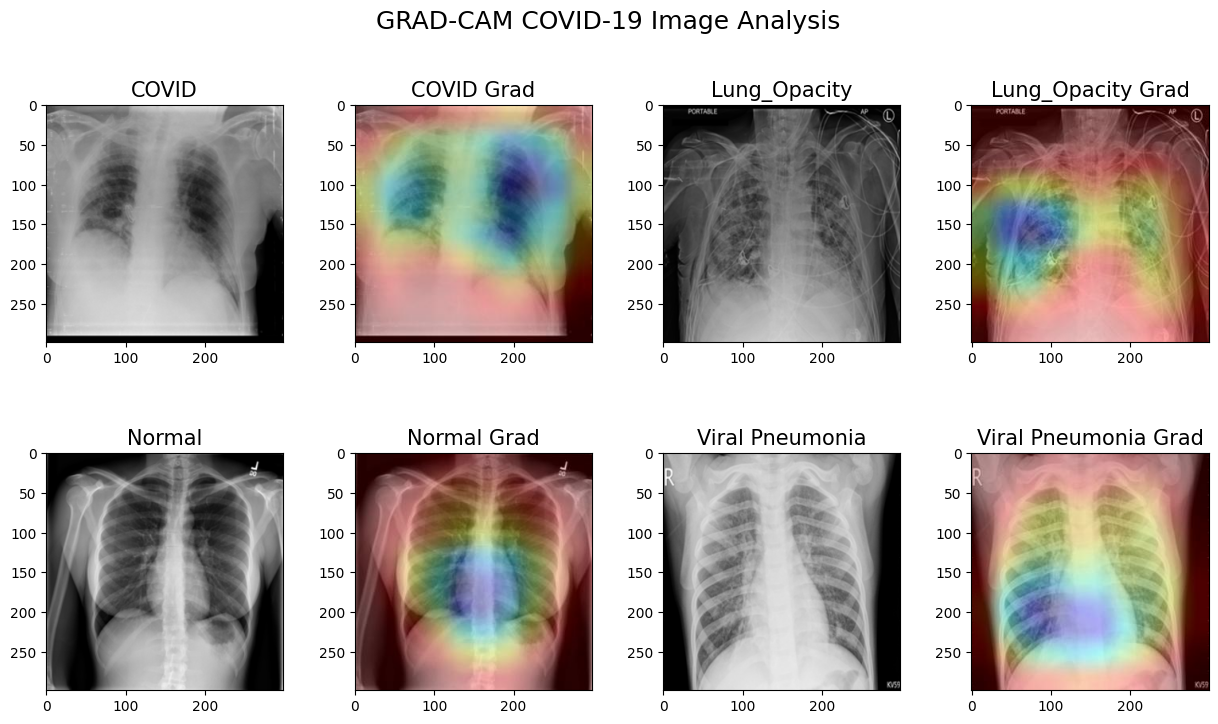

In [111]:
titles_list = ['COVID','COVID Grad','Lung_Opacity','Lung_Opacity Grad','Normal','Normal Grad',"Viral Pneumonia",'Viral Pneumonia Grad']
#Puede que el título no coincida con la imagen, para solucionarlo habría que hacer una función

plot_multiple_img(imag, titles_list, ncols = 4, main_title = "GRAD-CAM COVID-19 Image Analysis")
